### Miguel Conner Bonmati

# Notebook Summary

In this notebook, we will try to model the population of France using economic data and other measures. 

Our main findings are: 

* Using ARIMA, we can model the population with: $$\texttt{ARIMA(1,3,1)}$$
* Using a VAR analysis, we can model the population with: 
$$\hat{p}_t = 1.65 p_{t-1} + 0.65 m_{t-1} -0.65 p_{t-2} + 3165.04 c_{t-2} - 1034143.59$$


where $p$ is population, $m$ the net migration, and $c$ the monthly consumer confidence.


We will proceed in the following order.

1. Load Data
2. Exploratory Analysis
3. ARIMA
4. VAR
5. Conclusions

In [238]:
#  import sys
#  !{sys.executable} -m pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
PATH = '/Users/Miguel/Desktop/Citibeats_Assesment/'

# 1. Load Data

Our data sources are:

* French Population,
* Ext. Balance Contribution to GPD (quarterly), 
* GDP (annually), 
* Monthly Consumer Confidence (monthly), and
* Unemployment Rate (quarterly)

In [239]:
# census data
pop = pd.read_excel(PATH+'french_pop.xlsx', skiprows=2, skipfooter=6, usecols=lambda x: 'Unnamed' not in x)
pop = pop.replace('na', np.NaN)

# external balance contribution to GDP
eb_q = pd.read_csv(PATH+'extermal_balance_contribution_to_GDP_growth/quarterly_values.csv', sep=';', skiprows=3)
eb_q.columns = ["quarter", "cont", "code"]
eb_codes = pd.read_csv(PATH+'extermal_balance_contribution_to_GDP_growth/characteristics.csv', sep=';', skiprows=4)

eb_a = eb_q
eb_a['year'] = eb_a['quarter'].str[:4]
eb_a = eb_a.groupby(['year']).mean(numeric_only=True).reset_index()
eb_a['year'] = pd.to_numeric(eb_a['year'])

# GDP
gdp_a = pd.read_csv(PATH+'GDP/annual_values.csv', sep=';', skiprows=3)
gdp_a.columns = ["year", "gdp", "code"]
gdp_codes = pd.read_csv(PATH+'unemployement_rate/characteristics.csv', sep=';', skiprows=4)

# MCC
mcc_m = pd.read_csv(PATH+'monthly_consume_confidence/monthly_values.csv', sep=';', skiprows=3)
mcc_m.columns = ["month", "mcc", "code"]
mcc_m = mcc_m.iloc[::-1] # reverse order of df
mcc_codes = pd.read_csv(PATH+'unemployement_rate/characteristics.csv', sep=';', skiprows=4)

mcc_a = mcc_m
mcc_a['year'] = mcc_a['month'].str[:4]
mcc_a = mcc_a.groupby(['year']).mean(numeric_only=True).reset_index()
mcc_a['year'] = pd.to_numeric(mcc_a['year'])

# unemployment
ue_q = pd.read_csv(PATH+'unemployement_rate/quarterly_values.csv', sep=';',skiprows=3)
ue_q.columns = ["quarter", "ue", "code"]
ue_q = ue_q.iloc[::-1]
ue_codes = pd.read_csv(PATH+'unemployement_rate/characteristics.csv', sep=';', skiprows=4)

ue_a = ue_q
ue_a['year'] = ue_a['quarter'].str[:4]
ue_a = ue_a.groupby(['year']).mean(numeric_only=True).reset_index()
ue_a['year'] = pd.to_numeric(ue_a['year'])

Above, we have imported all of the data. 

We have aggregated the non annual datasets into annual frequencies so we can compare them directly. We used a simple mean, since it seemed most appropriate for the measurements. The "_a" suffix of the dataframe variable name refers to annual frequencies, while "_q" is quarterly and "_m" is monthly.

Now, we will combine all into one dataframe df and generate a profile report, which will give us some ideas about how to proceed.

# 2. Exploratory Data Analysis

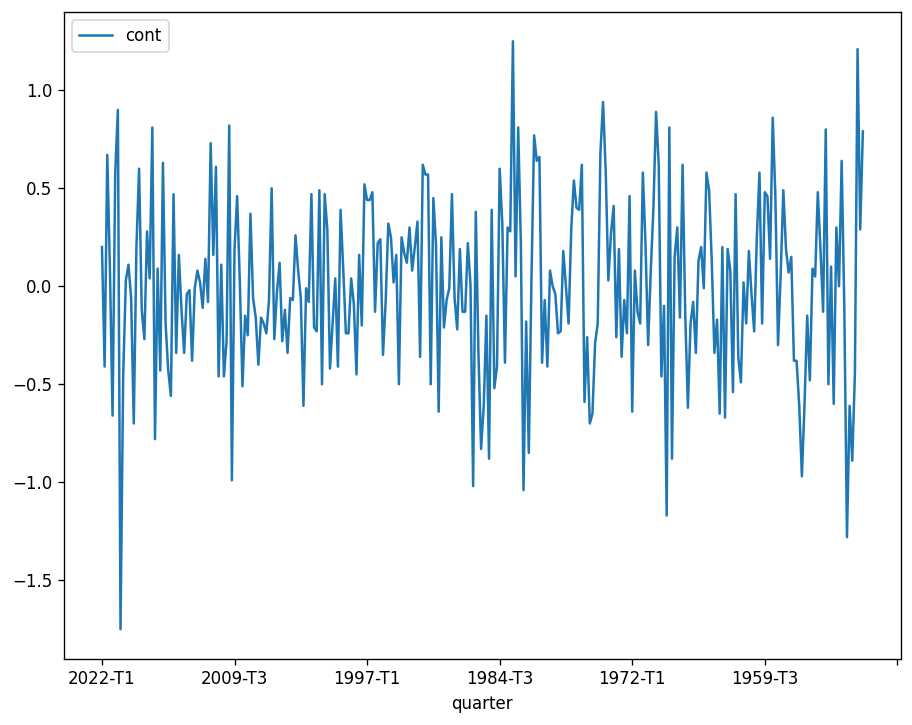

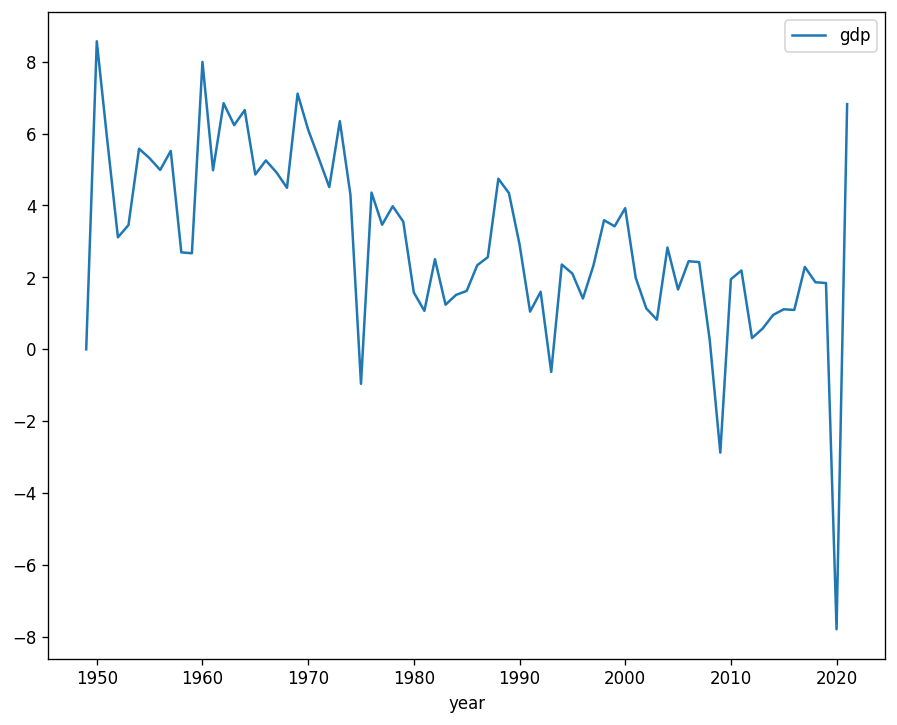

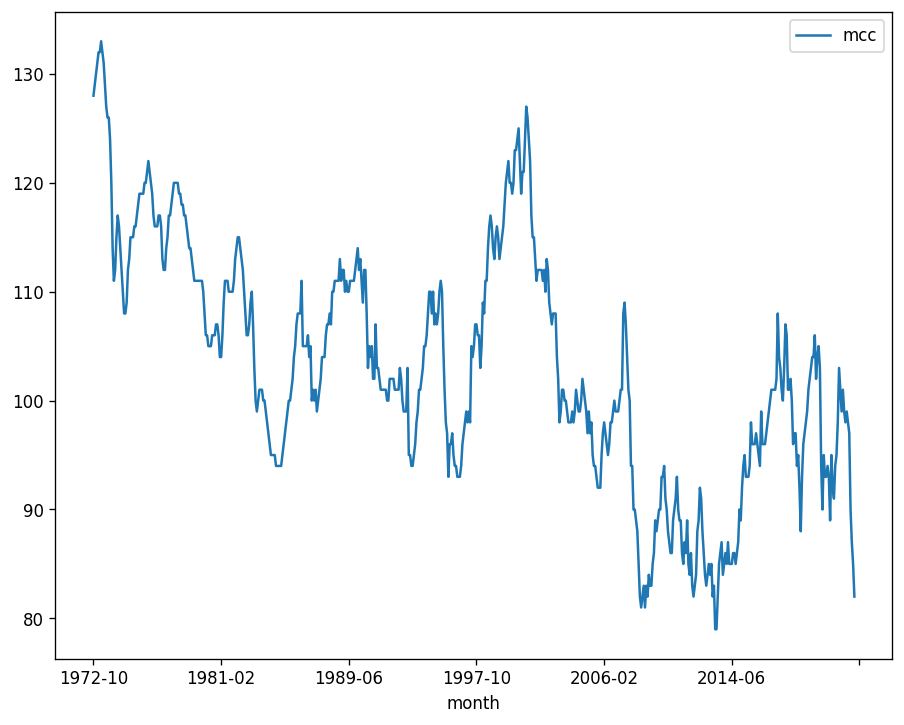

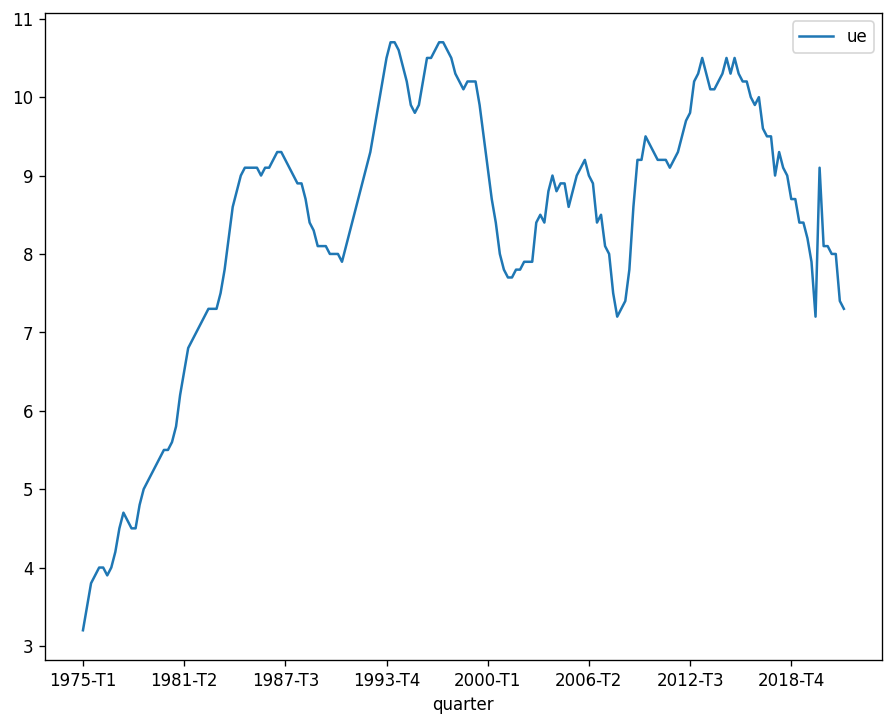

In [240]:
datasets = (eb_q, gdp_a, mcc_m, ue_q) #pop

for dset in datasets:
    dset.plot(x=0, y=1)

Quick notes on plots
1. ext. bal: seems to stay around 0
2. gdp: slight decrease over time
3. mcc: more significant decrease over time, dip in 2008
4. ue: large increase in the 70s and 80s, but has more or less remained in the 8-11 range in the past 30 years

Now lets take a deeper look at some of the data by compiling a profile report which will go through our data and find any correlations, interactions, or other potentially interesting info.

In [241]:
df = pop.merge(gdp_a.iloc[: , :-1], left_on='Year', right_on='year', how='left')
df = df.merge(mcc_a, left_on='Year', right_on='year', how='left')
df = df.merge(ue_a, left_on='Year', right_on='year', how='left')
df = df.merge(eb_a, left_on='Year', right_on='year', how='left')
df = df.drop(['year_x', 'year_y', 'year_x', 'year_y'], axis=1)
df = df.rename(columns={'Population on january, first':'population'})

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_40485/2039860718.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(eb_a, left_on='Year', right_on='year', how='left')


In [242]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df[-50:-1], tsmode=True, sortby="Year", infer_dtypes=False)
profile.to_file('profile_report.html')

Summarize dataset:   0%|                                  | 0/5 [00:00<?, ?it/s]/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/multimethod/__init__.py:315: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  return func(*args, **kwargs)
Summarize dataset:   0%|          | 0/16 [00:00

The report is exported as 'profile_report.html' and gives us a good snapshot of the data. Some things to mention:

* We are missing some values in some of our extra data. Around 1940s and 1950s

* Our data is not stationary except for external balance contribution

* The autocorrelation plots for the remaining variables vary, but 

# 3. ARIMA

## Making Non-Stationary Population Variable Stationary

Before proceeding with additional analysis, we will try to make our variables stationary. We will start with population and see what our ACF and PACF plots in the report say. It looks like in our PACF plot has the first variable outside of the range, meaning we would set p=1 for our AR model. The ACF plot is a little more unclear, but the plot would suggest a value of q=4. We can try out different things and see what they look like.  

We will also check the augmented Dickey–Fuller (ADF) statistic. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In [243]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

result = adfuller(df.population.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.369178
p-value: 0.150625


The p-val is greater than 0.05 so we will difference the series and see what the autocorrelation plot looks like.

In [244]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

result = adfuller(df.population.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.834175
p-value: 0.053555


In [245]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

result = adfuller(df.population.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.482583
p-value: 0.000000


We see that after doing two differences however, we end up with a significant p value and a very negative ADF statistic; perfect! We are stationary.

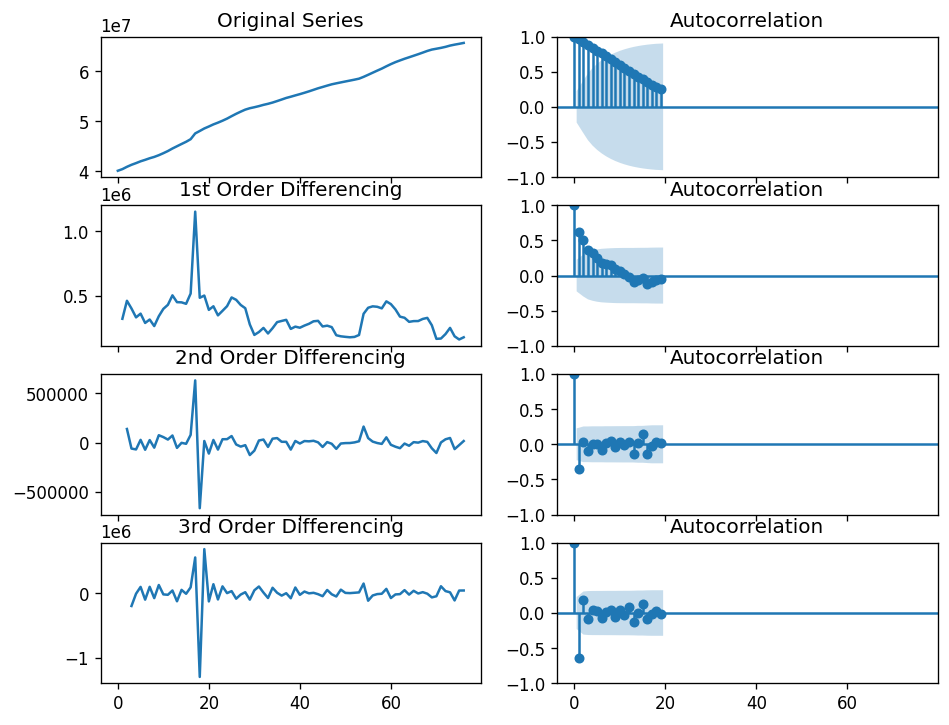

In [246]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(df.population); axes[0, 0].set_title('Original Series')
plot_acf(df.population, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.population.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.population.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.population.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.population.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(df.population.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(df.population.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [247]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(df.population, order=(1,1,4))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             population   No. Observations:                   77
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -998.482
Date:                Thu, 29 Dec 2022   AIC                           2008.964
Time:                        14:40:29   BIC                           2022.948
Sample:                             0   HQIC                          2014.553
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9919      0.002    425.315      0.000       0.987       0.996
ma.L1         -0.9870      0.020    -48.688      0.000      -1.027      -0.947
ma.L2          0.0035      0.033      0.104      0.9

A P value that is less than 0.05 means we should take that coefficient. The above plot suggests that we should take p = 1 and q = 1. Let's try to find a good value for d, incorporating some of the order difference plots above. We will try out a couple and keep an eye on the BIC, which is a measurement that helps us compare models while also ensuring they aren't too complex (overfit).

In [248]:
# 1,1,1 ARIMA Model
model = ARIMA(df.population, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             population   No. Observations:                   77
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -999.668
Date:                Thu, 29 Dec 2022   AIC                           2005.336
Time:                        14:40:29   BIC                           2012.329
Sample:                             0   HQIC                          2008.131
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9923      0.002    466.919      0.000       0.988       0.996
ma.L1         -0.9848      0.003   -339.312      0.000      -0.991      -0.979
sigma2      1.187e+10    5.3e-15   2.24e+24      0.0

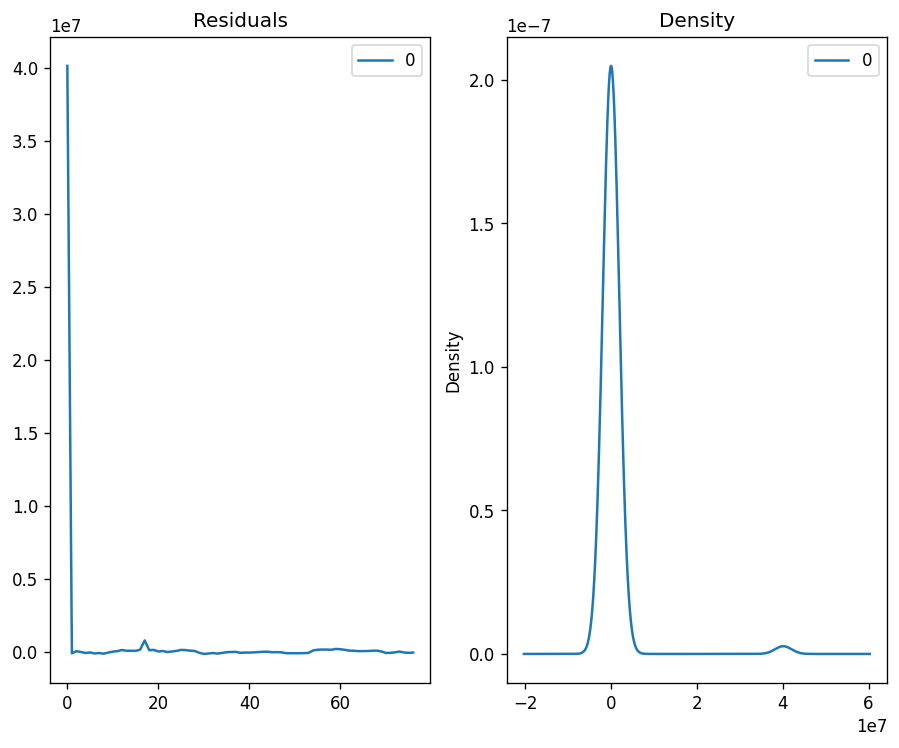

In [249]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Indeed, after trying out a few, we find that the lowest BIC is given for d = 3 (1949.2 vs. 1976.2 for d=2 vs. 1967 for d=4), shown below. This gives us coefficients of ar.L1: -0.3601 and ma.L1: -0.9289 with significant p values.

In [250]:
# 1,3,1 ARIMA Model
model = ARIMA(df.population, order=(1,3,1)) #p, d, q
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             population   No. Observations:                   77
Model:                 ARIMA(1, 3, 1)   Log Likelihood                -968.149
Date:                Thu, 29 Dec 2022   AIC                           1942.298
Time:                        14:40:29   BIC                           1949.210
Sample:                             0   HQIC                          1945.055
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3601      0.049     -7.338      0.000      -0.456      -0.264
ma.L1         -0.9289      0.029    -31.956      0.000      -0.986      -0.872
sigma2      1.763e+10   6.29e-13    2.8e+22      0.0

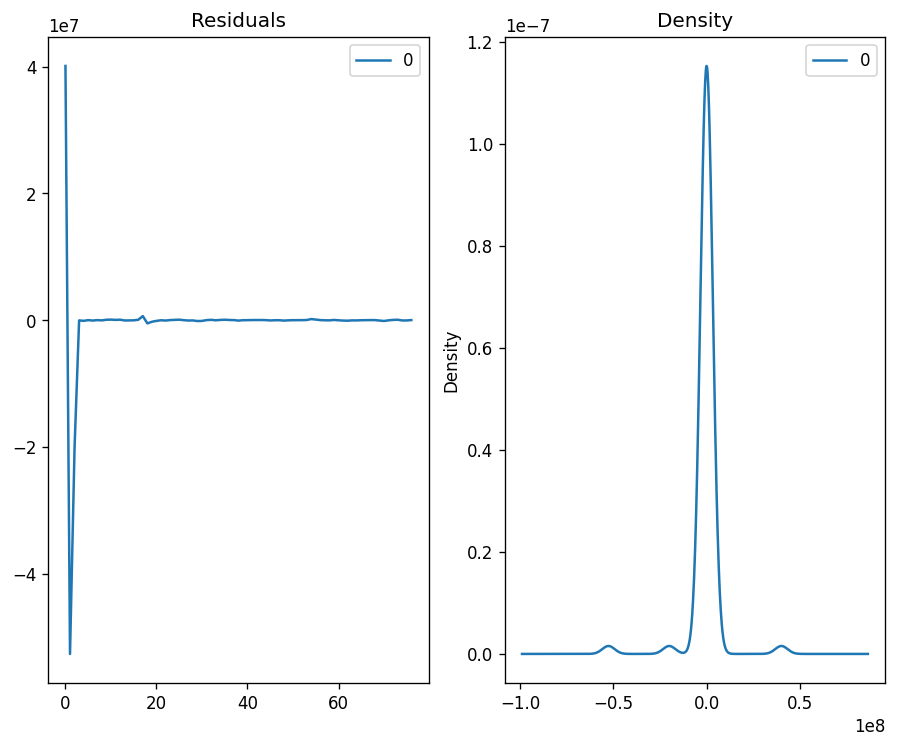

In [251]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

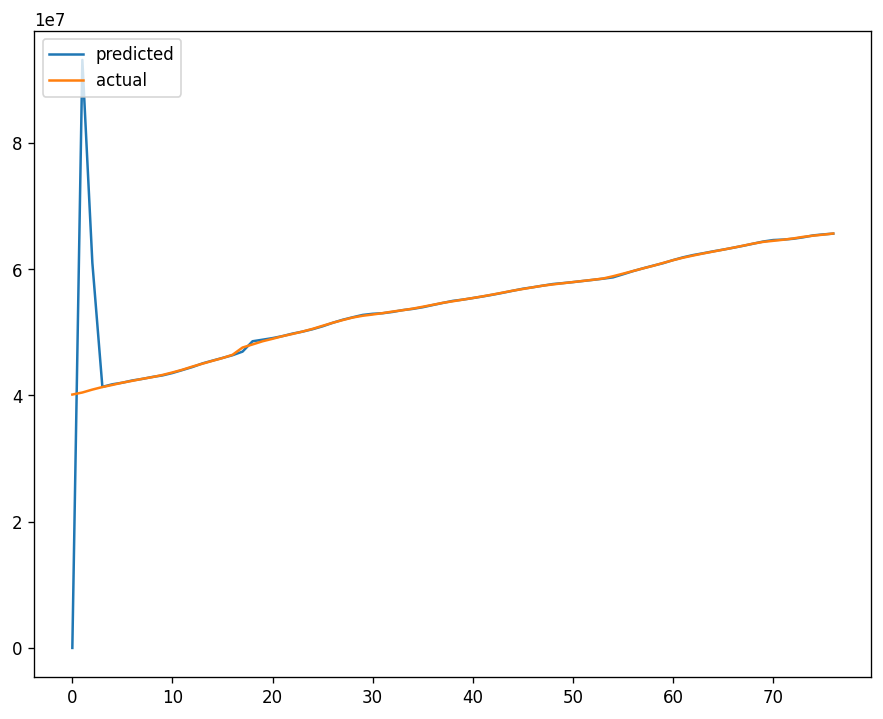

In [252]:
# Actual vs Fitted
pred = model_fit.predict(dynamic=False)
plt.plot(pred, label="predicted")
plt.plot(df.population, label="actual")
plt.legend(loc="upper left")
plt.show()

For some reason, we have this big spike in some of our predictions because we aren't getting the right intercept and our model starts at 0. We will need to investigate further later, but for now it looks like we would probably get a pretty good estimate for our 2023 prediction using this model.

## Test Predictions with (1, 3, 1) ARIMA

In [253]:
from statsmodels.tsa.stattools import acf

# Create training and test set just to get a sense for how "well" our model is predicting.
train = df.population[:66]
test = df.population[66:]

model = ARIMA(train, order=(1, 3, 1))  
fitted = model.fit() 


In [254]:
forecast = fitted.get_forecast(20)
fc = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)
upper = ci['upper population']
lower = ci['lower population']

In [255]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(lower, index=test.index)
upper_series = pd.Series(upper, index=test.index)

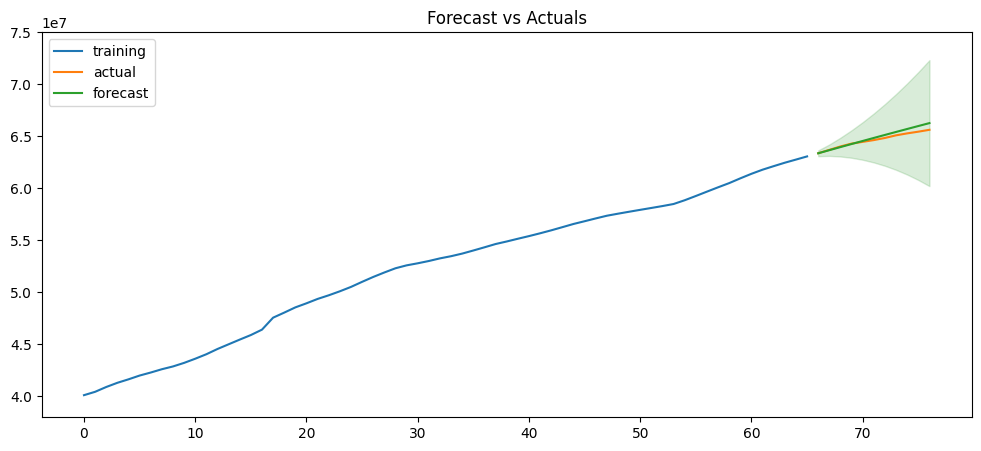

In [256]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='green', alpha=.15
                )
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.ylim([38000000, 75000000])
plt.show()

The actual trend in population is fairly close to our predictions, and is certainly well within our confidence interval. This gives us confidence in our model, and we will now try predicting population increase over the next 20 years with the full population dataset.

In [257]:
arima_err = fc_series -test
arima_err = [(va*va)**0.5 for va in arima_err]
arima_err = sum(arima_err)
arima_err

2651429.8029499426

## Actual Predictions with ARIMA (1, 3, 1)

In [258]:
model = ARIMA(df.population[:-1], order=(1, 3, 1))  
fitted = model.fit() 

In [259]:
forecast = fitted.get_forecast(20)
fc = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)
upper = ci['upper population']
lower = ci['lower population']

In [260]:
# Make as pandas series
fc_series = pd.Series(fc, index=fc.index)
lower_series = pd.Series(lower, index=fc.index)
upper_series = pd.Series(upper, index=fc.index)

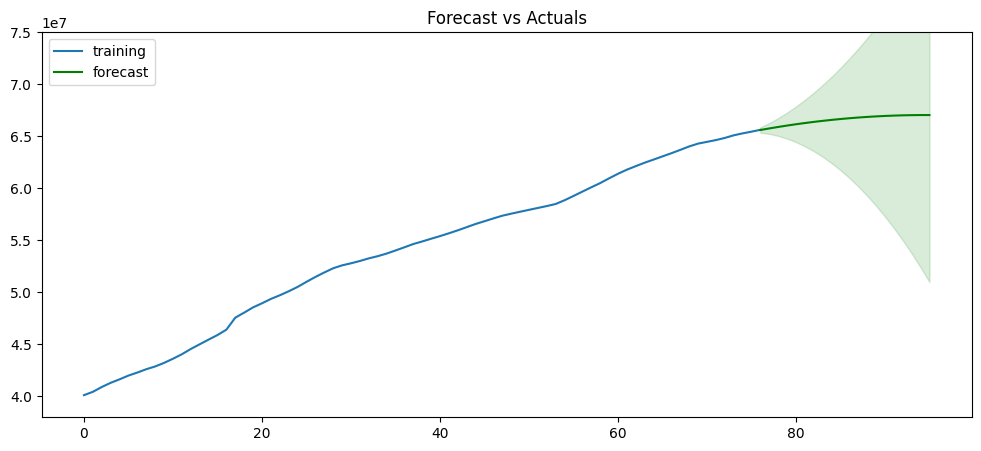

In [261]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df.population, label='training')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='green', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.ylim([38000000, 75000000])
plt.show()

In [262]:
arima_pred = pd.DataFrame({'year' : range(2022, 2042) , 'apopulation':list(fc.values)})
arima_pred = round(arima_pred)

Interestingly, our model is predicting that the population will begin to level off in the next 20 years, assuming the current trends continue.

# 4. VAR Model

We will now try to implement some of our other data using VAR models. First we take a look to see if they are stationary with one difference, just to get a sense for the data.

In [263]:
diff_df = df.diff()

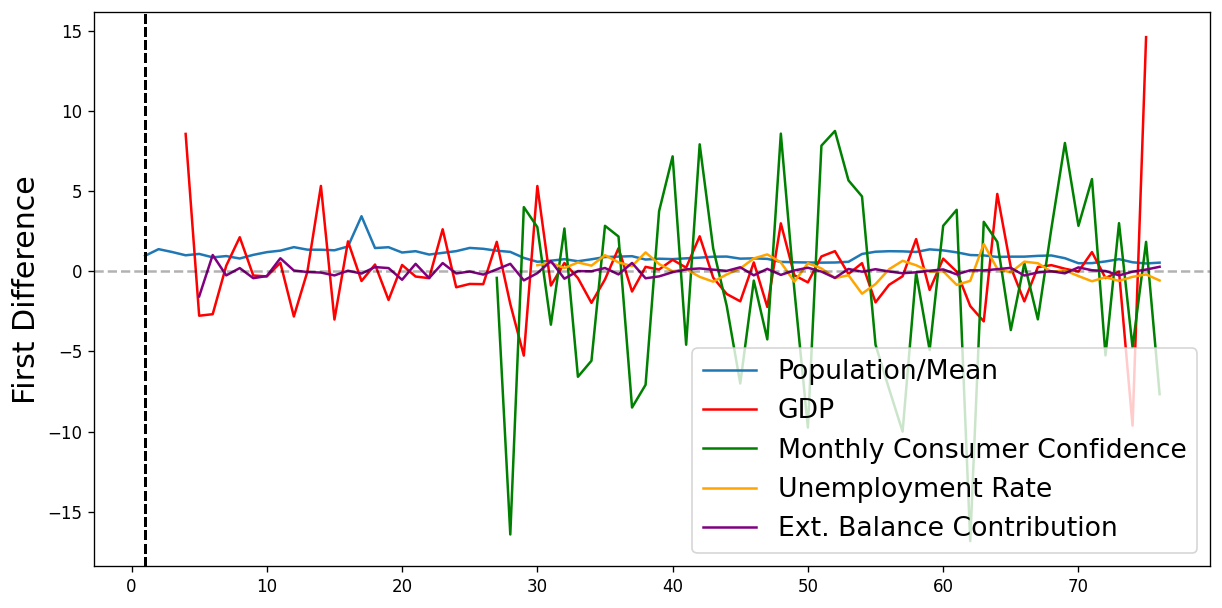

In [264]:
plt.figure(figsize=(12,6))
pop, = plt.plot(diff_df['population']/diff_df['population'].mean())
gdpp, = plt.plot(diff_df['gdp'], color='red')
mccp, = plt.plot(diff_df['mcc'], color='green')
uep, = plt.plot(diff_df['ue'], color='orange')
contp, = plt.plot(diff_df['cont'], color='purple')

for year in diff_df['Year']:
    plt.axvline(year, linestyle='--', color='k', alpha=0.5)
    
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Population/Mean','GDP', 'Monthly Consumer Confidence', 'Unemployment Rate', 'Ext. Balance Contribution'], fontsize=16)

These seem fairly stationary (fluctuate around zero fairly regularly and the spikes don't seem to get that much bigger, except for 2020--covid) so we will use them in our model. This seems in line with our ACF and PACF plots in the report we generated.

In [265]:
var_df = df.dropna().drop(['Year', 'Adjustment (a)'], axis=1)

In [266]:
v_mod = VAR(var_df)

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [267]:
model_fit = v_mod.fit(maxlags=2)

In [268]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Dec, 2022
Time:                     14:40:31
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    69.8627
Nobs:                     45.0000    HQIC:                   65.5567
Log likelihood:          -1821.11    FPE:                3.79881e+27
AIC:                      62.9974    Det(Omega_mle):     1.49815e+26
--------------------------------------------------------------------
Results for equation population
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                -1034143.590551    521620.554693           -1.983           0.047
L1.population               1.651931         0.149709           11.034           0.000
L1.Births                   0.6

Looking at the section titled 'Results for equation population', we see the coefficients with prob < 0.05 are:
    
* L1.population (0.000)
* L1.Net migration (0.012)
* L2.population (0.000)
* L2.mcc (0.031)
* constant (0.047)

Giving us an equation of:

$$\hat{p}_t = 1.65 p_{t-1} + 0.65 m_{t-1} -0.65 p_{t-2} + 3165.04 c_{t-2} - 1034143.59 $$

where $p$ is population, $m$ the net migration, and $c$ the monthly consumer confidence.

## Test VAR Predictions

In [269]:
# Create training and test set just to get a sense for how "well" our model is predicting.
train = var_df[:37]
test = var_df[-10:]

v_mod = VAR(train)
modelv_fit = v_mod.fit(maxlags=2)

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [270]:
b = modelv_fit.forecast(train.values[-2:], steps = 10)
b = pd.DataFrame(b)
var_predt = pd.DataFrame({'vpopulation': round(b[0])})
var_predt = var_predt.set_index([[66, 67, 68, 69, 70, 71, 72, 73, 74, 75]])
test

,population,Births,Deaths,Natural increase,Net migration,gdp,mcc,ue,cont
66,63375971,790290.0,559227.0,231063.0,90831.0,0.313,86.416667,9.800,-0.0075
67,63697865,781621.0,558408.0,223213.0,106880.0,0.576,83.416667,10.300,-0.0825
68,64027958,781167.0,547003.0,234164.0,38699.0,0.956,86.083333,10.275,-0.0850
69,64300821,760421.0,581770.0,178651.0,53025.0,1.113,94.083333,10.325,-0.2150
70,64468792,744697.0,581073.0,163624.0,87964.0,1.095,96.916667,10.025,0.0250
71,64639133,730242.0,593606.0,136636.0,166654.0,2.291,102.666667,9.400,0.0875
72,64844037,719737.0,596552.0,123185.0,211349.0,1.865,97.416667,9.025,0.1025
73,65096768,714029.0,599408.0,114621.0,155000.0,1.843,100.416667,8.425,-0.1550
74,65284389,696664.0,654599.0,42065.0,155000.0,-7.785,95.666667,8.075,-0.1825
75,65447454,698000.0,639000.0,59000.0,155000.0,6.817,97.500000,7.875,-0.0775


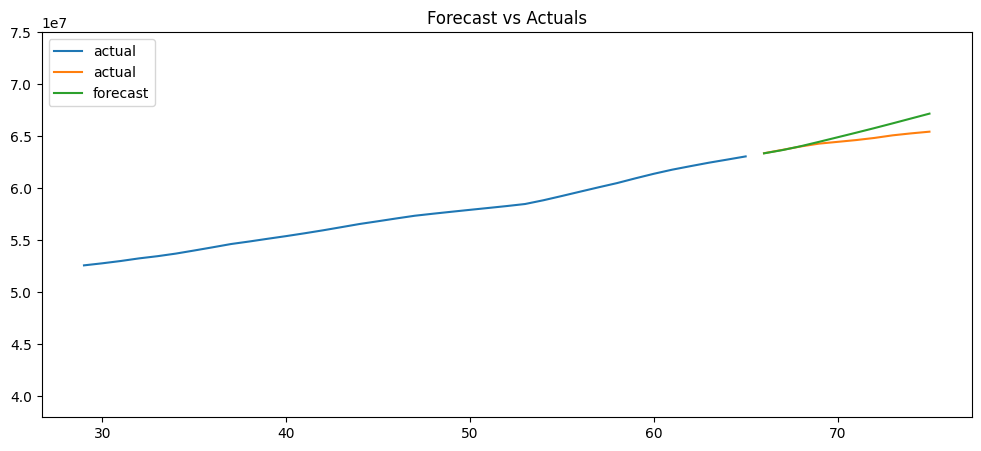

In [271]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.population, label='actual')
plt.plot(test.population, label='actual')
plt.plot(var_predt.vpopulation, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.5)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.ylim([38000000, 75000000])
plt.show()

Here we see that our forecast is predicting in slightly the wrong direction; the actual trend decreases slightly and the forcast increases. Next we will use all the training data to predict the next 20 years. Finally, we will compare this with the ARIMA model.

In [272]:
var_predt['vpopulation'] = [int(val) for val in var_predt['vpopulation']]
var_err = var_predt['vpopulation'] - test['population']
var_err = [(va*va)**0.5 for va in var_err]
var_err = sum(var_err)
var_err

6629943.0

In [273]:
["{:e}".format(arima_err), "{:e}".format(var_err)]

['2.651430e+06', '6.629943e+06']

Above we compare the mean squared error of our test set for our ARIMA model and our VAR model. We see that we are quite a bit closer on our ARIMA model (though it is not an order of magnitude difference). This gives us a general sense that the ARIMA is perhaps better suited for this kind of analysis. 

## Actual VAR Predictions

In [274]:
model_fit.k_ar

2

In [275]:
a = model_fit.forecast(var_df.values[-2:], steps = 20)
a = pd.DataFrame(a)
var_pred = pd.DataFrame({'year': range(2022, 2042),'vpopulation': round(a[0])})
var_pred = var_pred.set_index([[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]])

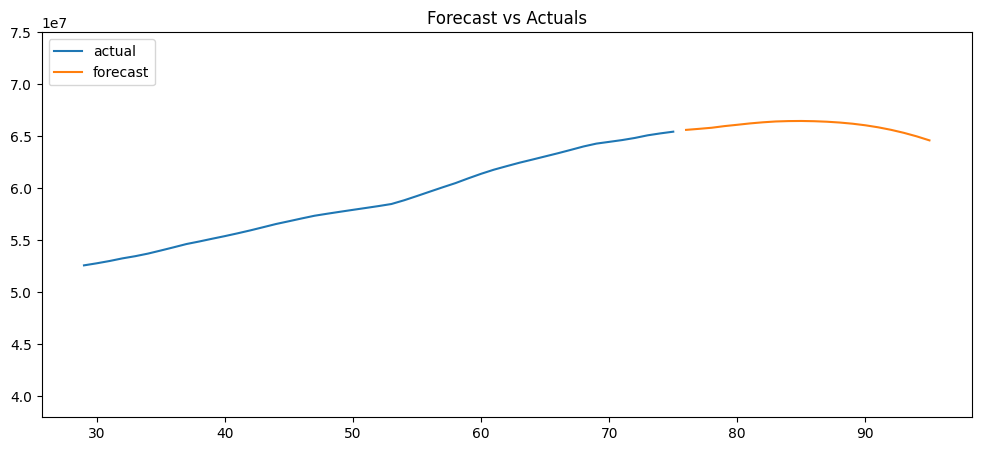

In [276]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(var_df.population, label='actual')
plt.plot(var_pred.vpopulation, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.5)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.ylim([38000000, 75000000])
plt.show()

We see that in this prediction our population more plateaus, it begins taking a heavy dip! 

# 5. Conclusion

The comparison of our predictions are given in the shortened data table, and the plot below. We see that our both predictions suggest a plateau and an eventual decline, barring any major interruptions. We see that the VAR model predicts this decline sooner.

Assuming our models are correct, one would be tempted to put more weight on the VAR model since it is including data from different potential variables that could influence the observed variable, unlike our ARIMA model which is just predicts the trend from how the trend has looked in the past. 

In [277]:
final_pred = var_pred.merge(arima_pred, left_on='year', right_on='year', how='left')
final_pred = final_pred.set_index([[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]])
final_pred['prediction difference'] = final_pred['vpopulation'] - final_pred['apopulation']
final_pred[[True if y in [2022, 2027, 2032, 2037] else False for y in final_pred['year']]]

,year,vpopulation,apopulation,prediction difference
76,2022,65620324.0,65608019.0,12305.0
81,2027,66242862.0,66277671.0,-34809.0
86,2032,66452859.0,66739337.0,-286478.0
91,2037,65866637.0,66992601.0,-1125964.0


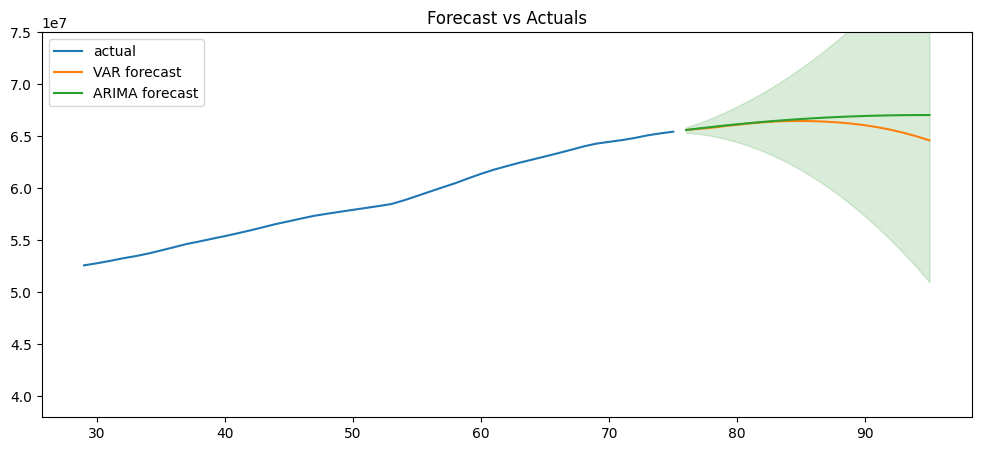

In [278]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(var_df.population, label='actual')
plt.plot(final_pred.vpopulation, label='VAR forecast')
plt.plot(final_pred.apopulation, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='green', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=10)
plt.ylim([38000000, 75000000])
plt.show()

We came up with two ways of estimating that were pretty close. With more time, we could try:

* finding ways of getting more robust error measurements for each of the two models,
* using all of our data in our VAR model,
* getting confidence intervals for our VAR model,
* using more detailed frequencies in some of the data.